# Liver Segmentation

All of the whole slide images have regions corresponding to the organ per se and empty regions corresponding either to background or vessels (blood vessels or bile ducts). In this pipeline we will look for these organs. An optional objective will be to detect accessory vessels as well.

In [1]:
from pathlib import Path

import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import (
    binary_opening,
    disk,
    label,
    remove_small_objects,
    remove_small_holes,
)
from skimage.measure import regionprops

from gulliver.io import get_image

c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


First we should choose the image file, select the scene and load the array.

In [2]:
DATA_DIR = Path("../data/Ndr better settings_2.czi")

In [3]:
image = get_image(DATA_DIR, 0)

We can use the nuclei staining channel, perform some gross blurring, and apply Otsu thresholding.

In [4]:
nuclei_channel = gaussian(np.mean(image["DAPI"]["image"], axis=0), 20)

In [5]:
threshold = threshold_otsu(nuclei_channel)

In [6]:
liver_masks = nuclei_channel > threshold

Now that we have a mask, we can do some opening to remove small nuclei and smooth borders. We can apply algorithms to remove holes and small objects we don't care about. Let's end with a labelling step to enumerate with an identifier each structure.

In [7]:
liver_masks = binary_opening(
    liver_masks, footprint=disk(30, decomposition="sequence")
)

In [8]:
liver_masks = remove_small_holes(liver_masks, area_threshold=10**8)

In [9]:
liver_masks = label(liver_masks)

In [10]:
liver_masks = remove_small_objects(liver_masks, min_size=10000)

C:\Users\agucor\AppData\Local\Temp\ipykernel_712\1146585010.py:1: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  liver_masks = remove_small_objects(liver_masks, min_size=10000)


In [11]:
areas = regionprops(liver_masks)

In [12]:
for area in areas:
    print(area.area)

240074914.0


28-Dec-23 14:56:56 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).
c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (27766, 25931) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (27766, 25931) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (27766, 25931) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\

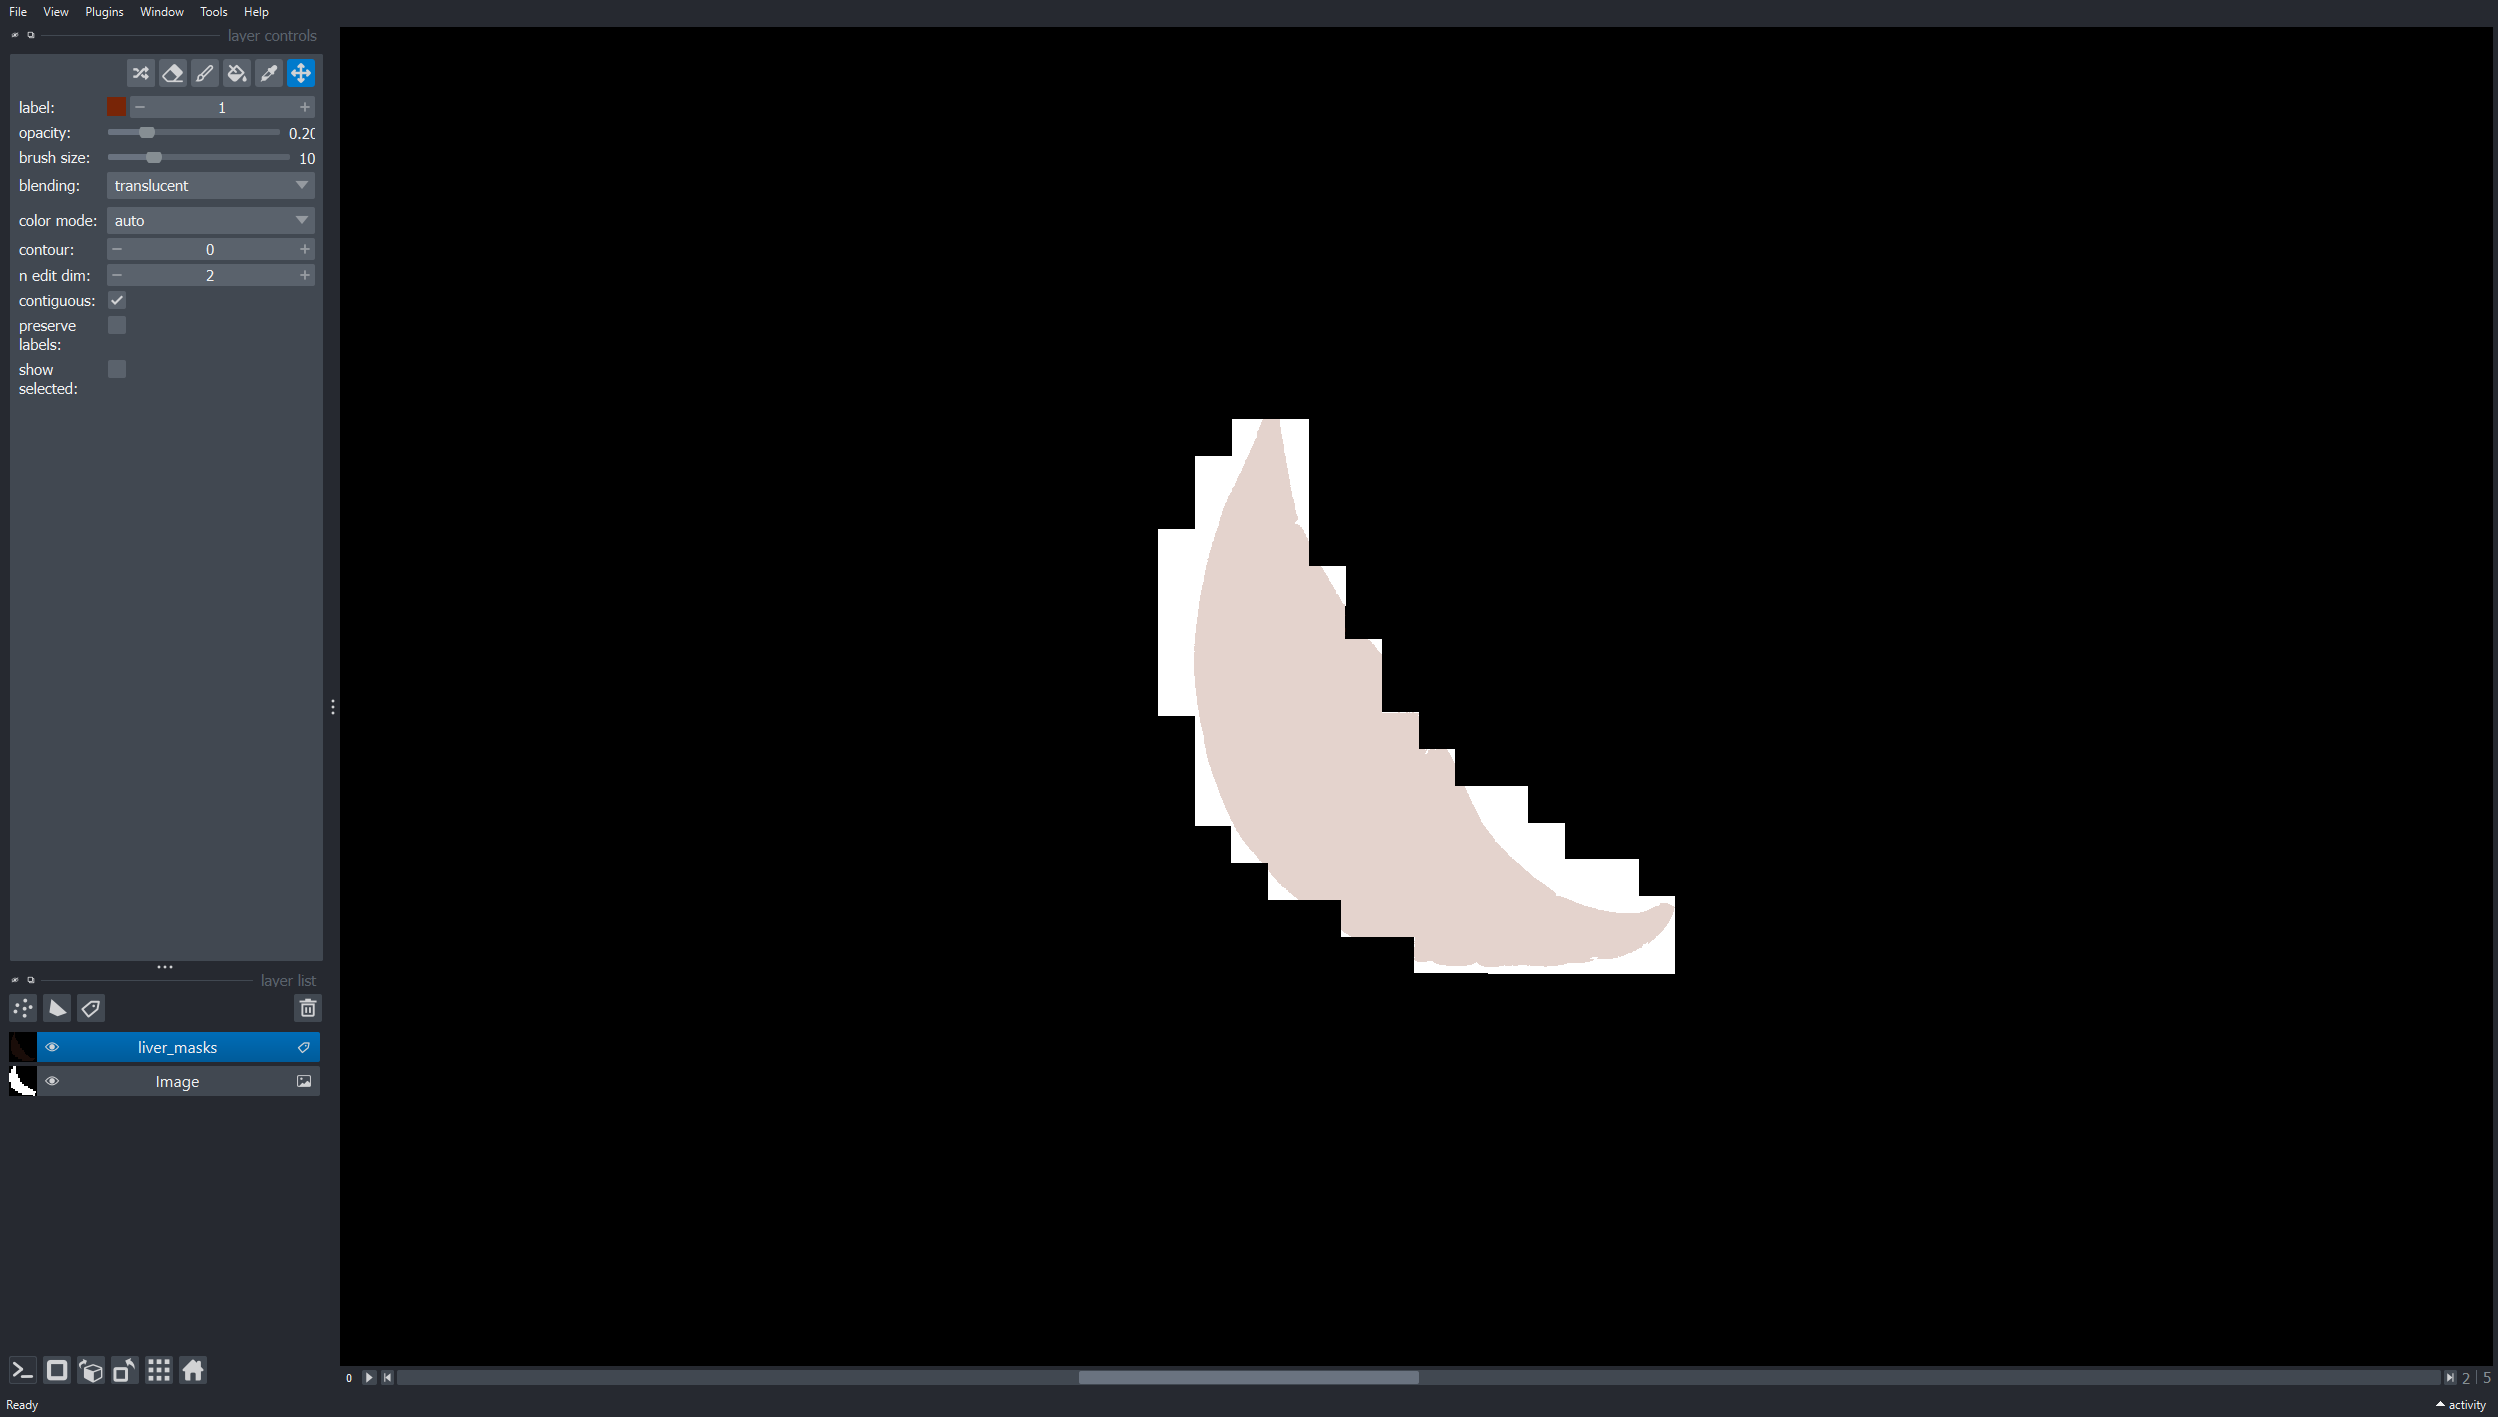

In [13]:
import napari

viewer = napari.Viewer()
viewer.add_image(image["DAPI"]["image"])
viewer.add_labels(liver_masks, opacity=0.2)
napari.utils.nbscreenshot(viewer)

The areas detected and the regions look good.